Importando bibliotecas

In [1]:
import gsidiag as gd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from itertools import combinations
import seaborn as sns


Definindo parâmetros para o uso do readDiag

In [3]:
DIRdiag = "/home/patrick/readDiag/data"

varName = "amsua"
varType = "n15"
dateIni="2020010100" 
dateFin="2020010106" 
nHour = "6"          
vminOMA = -2.0       
vmaxOMA = 2.0        
vminSTD = 0.0        
vmaxSTD = 14.0       
Level = 1000
Lay = None           
SingleL = "All" 

datei = datetime.strptime(str(dateIni), "%Y%m%d%H")
datef = datetime.strptime(str(dateFin), "%Y%m%d%H")
dates = [dates.strftime('%Y%m%d%H') for dates in pd.date_range(datei, datef,freq="6H").tolist()]

print(dates)


['2020010100', '2020010106']


Encontrando e listando arquivos para serem usados

In [4]:
paths, pathsc = [], []

OuterL = "01"        
[paths.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterL+"."+dt) for dt in dates]

OuterLc = "03"
[pathsc.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterLc+"."+dt) for dt in dates]

print(paths)
print("")
print(pathsc)

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106']

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_03.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_03.2020010106']


Definição da função para discretizar os dados de impacto:

In [5]:
# Função que retorna a categoria:
def categoria_de(valorRF):
    categoria = None
    if valorRF <= -0.25:
        categoria = "Impacto negativo alto"
    elif valorRF > -0.25 and valorRF < 0:
        categoria = "Impacto negativo baixo"
    elif valorRF == 0:
        categoria = "Impacto neutro"
    elif valorRF > 0 and valorRF < 0.25:
        categoria = "Impacto positivo baixo"
    elif valorRF >= 0.25:
        categoria = "Impacto positivo alto"
    return categoria

Lendo arquivos listado usando o readDiag e concatenando os dados

In [6]:
# Define uma variável booleana 'read' como True para indicar que a leitura dos arquivos será realizada
read = True

# Verifica se 'read' é True para prosseguir com a leitura dos arquivos
if read:        
    # Inicializa uma lista vazia para armazenar os objetos gdf
    gdf_list = []
    # Imprime uma mensagem informando o tempo estimado necessário para a leitura dos arquivos
    print("")
    print("Aguarde, o tempo total estimado para a leitura dos arquivos é de "+
          str(int((float(len(paths))*20 )/60))+" minutos e "+
          str(int((float(len(paths))*20 )%60))+" segundos.")
    print("")
    # Itera sobre os caminhos dos arquivos e seus caminhos de configuração correspondentes
    for path, pathc in zip(paths,pathsc):
        # Imprime uma mensagem indicando o arquivo que está sendo lido
        print("Reading "+path)
        # Lê o arquivo usando a função read_diag do módulo gsidiag e armazena o objeto retornado em gdf
        gdf = gd.read_diag(path,pathc)
        # Adiciona o objeto gdf à lista gdf_list
        gdf_list.append(gdf)

    # Imprime a lista de objetos gdf lidos
    print(gdf_list)
    
    # Define uma string separadora para uso posterior
    separator = " ====================================================================================================="



Aguarde, o tempo total estimado para a leitura dos arquivos é de 0 minutos e 40 segundos.

Reading /home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
 
>>> GSI DIAG <<<
 
Reading /home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106
 
>>> GSI DIAG <<<
 
[<gsidiag.__main__.read_diag object at 0x7fd5a553a5d0>, <gsidiag.__main__.read_diag object at 0x7fd5ac8ea790>]


In [7]:
# Inicialização de DataFrame vazio para armazenar dados concatenados
df_concatenado2 = pd.DataFrame()

# Iteração sobre objetos em gdf_list
for objeto in gdf_list:
        
    print(separator)
    print("Separando dados do arquivo" + str(objeto._diagFile))
    
    # Criação de dicionário de dados a partir do objeto   
    dados_dict = {
            'lat': objeto.obsInfo[varName].loc[varType].lat,
            'lon': objeto.obsInfo[varName].loc[varType].lon,
            'elev': objeto.obsInfo[varName].loc[varType].elev,
            'nchan': objeto.obsInfo[varName].loc[varType].nchan,
            'time': objeto.obsInfo[varName].loc[varType].time,
            'iuse': objeto.obsInfo[varName].loc[varType].iuse,
            'idqc': objeto.obsInfo[varName].loc[varType].idqc,
            'inverr': objeto.obsInfo[varName].loc[varType].inverr,
            'oer': objeto.obsInfo[varName].loc[varType].oer,
            'obs': objeto.obsInfo[varName].loc[varType].obs,
            'omf': objeto.obsInfo[varName].loc[varType].omf,
            'omf_nobc': objeto.obsInfo[varName].loc[varType].omf_nobc,
            'emiss': objeto.obsInfo[varName].loc[varType].emiss,
            'oma': objeto.obsInfo[varName].loc[varType].oma,
            'oma_nobc': objeto.obsInfo[varName].loc[varType].oma_nobc,
            'imp': objeto.obsInfo[varName].loc[varType].imp,
            'dfs': objeto.obsInfo[varName].loc[varType].dfs
            }
        
    # Conversão do dicionário em DataFrame
    df_objeto = pd.DataFrame(dados_dict)
    
    # Aplicação da função 'categoria_de' para criar a coluna 'imp_categ'
    df_objeto['imp_categ'] = df_objeto['imp'].apply(categoria_de)
        
    # Concatenação do DataFrame do objeto com o DataFrame concatenado
    df_concatenado2 = pd.concat([df_concatenado2, df_objeto], ignore_index=True)
    
    print(df_concatenado2)

Separando dados do arquivo/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
              lat         lon         elev  nchan      time  iuse  idqc  \
0      -87.504501   19.704599  2735.045410    1.0  0.315833   1.0   8.0   
1      -87.504501   19.704599  2735.045410    2.0  0.315833   1.0   8.0   
2      -87.504501   19.704599  2735.045410    3.0  0.315833   1.0   8.0   
3      -87.504501   19.704599  2735.045410    4.0  0.315833   1.0   8.0   
4      -87.504501   19.704599  2735.045410    5.0  0.315833   1.0   8.0   
...           ...         ...          ...    ...       ...   ...   ...   
112555 -16.086201  336.148102    -0.027625   11.0 -2.709445  -1.0  -3.0   
112556 -16.086201  336.148102    -0.027625   12.0 -2.709445   1.0   0.0   
112557 -16.086201  336.148102    -0.027625   13.0 -2.709445   1.0   0.0   
112558 -16.086201  336.148102    -0.027625   14.0 -2.709445  -1.0  -3.0   
112559 -16.086201  336.148102    -0.027625   15.0 -2.709445   1.0  51.0   

     

In [8]:
# Remoção de linhas com valores NaN
df_concatenado2.dropna(inplace=True)
    
print(df_concatenado2)

print(separator)
    
# Lista de atributos a serem usados para treinamento
atributos = ['nchan', 'omf', 'oma', 'dfs']
    
# Divisão dos dados em conjuntos de treinamento e teste
X = df_concatenado2[atributos]
y = df_concatenado2['imp_categ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
print('Treino e Teste prontos')
print(separator)

              lat         lon         elev  nchan      time  iuse  idqc  \
5      -87.504501   19.704599  2735.045410    6.0  0.315833  -1.0  -0.0   
6      -87.504501   19.704599  2735.045410    7.0  0.315833   1.0   0.0   
7      -87.504501   19.704599  2735.045410    8.0  0.315833   1.0   0.0   
8      -87.504501   19.704599  2735.045410    9.0  0.315833   1.0   0.0   
9      -87.504501   19.704599  2735.045410   10.0  0.315833   1.0   0.0   
...           ...         ...          ...    ...       ...   ...   ...   
209947  77.502502  358.795105    -0.108379    8.0  1.952778   1.0   0.0   
209948  77.502502  358.795105    -0.108379    9.0  1.952778   1.0   0.0   
209949  77.502502  358.795105    -0.108379   10.0  1.952778   1.0   0.0   
209951  77.502502  358.795105    -0.108379   12.0  1.952778   1.0   0.0   
209952  77.502502  358.795105    -0.108379   13.0  1.952778   1.0   0.0   

          inverr       oer         obs       omf  omf_nobc     emiss  \
5       3.557238  0.281441 

[ 6.  7.  8.  9. 10. 12. 13.  5.  1.  2.  3.  4. 15.]
Matriz de Confusão para o canal 6.0:
[[459  10   0   0]
 [  4 920   0   8]
 [  0   0 118   8]
 [  0  11   1 765]]


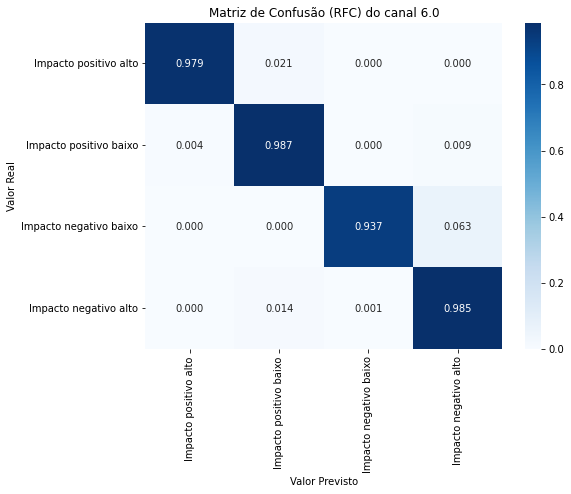

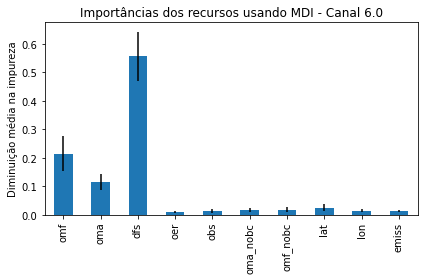


Relatório de Classificação para o canal 6.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.99      0.98      0.98       469
Impacto negativo baixo       0.98      0.99      0.98       932
 Impacto positivo alto       0.99      0.94      0.96       126
Impacto positivo baixo       0.98      0.98      0.98       777

              accuracy                           0.98      2304
             macro avg       0.99      0.97      0.98      2304
          weighted avg       0.98      0.98      0.98      2304

Matriz de Confusão para o canal 7.0:
[[ 417    1    0    0]
 [   0 1377    0    5]
 [   0    0   31    8]
 [   0   20    1  939]]


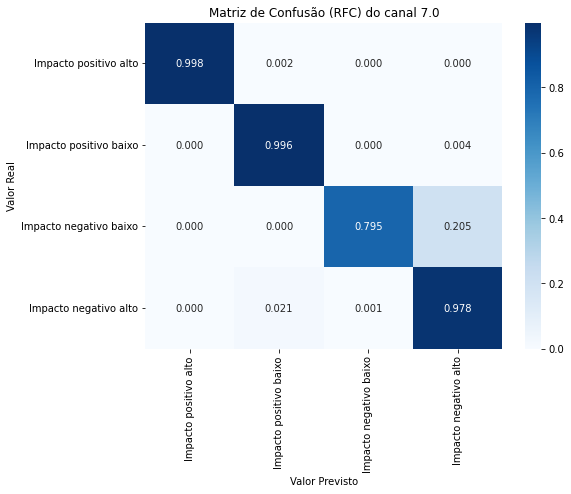

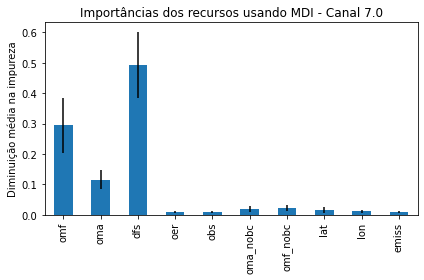


Relatório de Classificação para o canal 7.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       1.00      1.00      1.00       418
Impacto negativo baixo       0.98      1.00      0.99      1382
 Impacto positivo alto       0.97      0.79      0.87        39
Impacto positivo baixo       0.99      0.98      0.98       960

              accuracy                           0.99      2799
             macro avg       0.99      0.94      0.96      2799
          weighted avg       0.99      0.99      0.99      2799

Matriz de Confusão para o canal 8.0:
[[ 524    4    0    0]
 [   2 1365    0    8]
 [   0    0   23    4]
 [   0   17    2  851]]


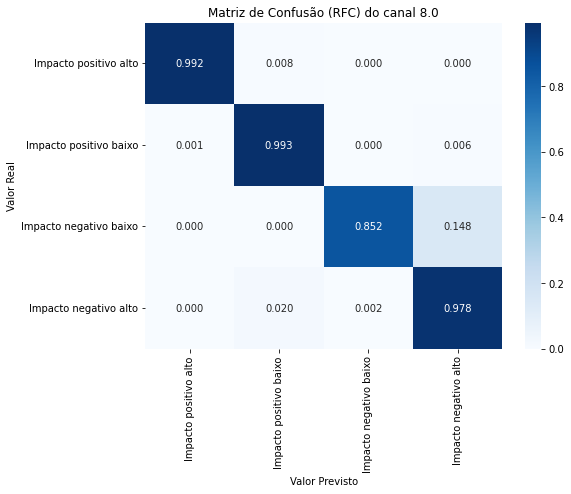

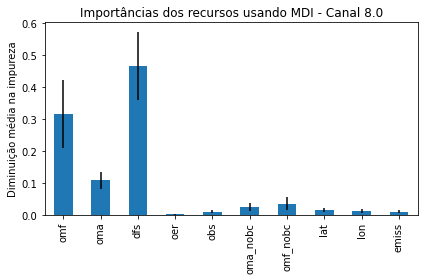


Relatório de Classificação para o canal 8.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       1.00      0.99      0.99       528
Impacto negativo baixo       0.98      0.99      0.99      1375
 Impacto positivo alto       0.92      0.85      0.88        27
Impacto positivo baixo       0.99      0.98      0.98       870

              accuracy                           0.99      2800
             macro avg       0.97      0.95      0.96      2800
          weighted avg       0.99      0.99      0.99      2800

Matriz de Confusão para o canal 9.0:
[[ 548    4    0    0]
 [   8 1274    0    5]
 [   0    0   38   13]
 [   0   16    2  892]]


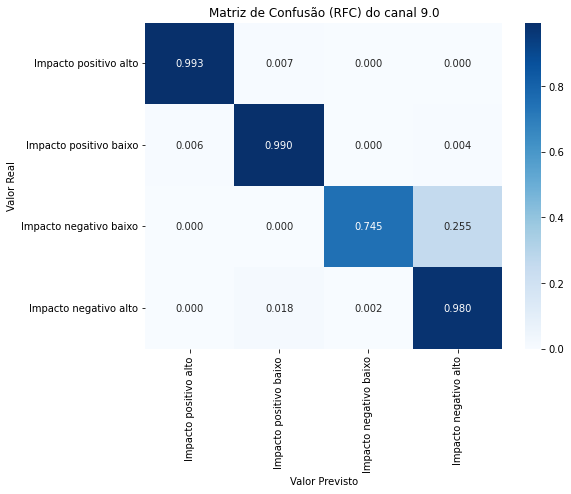

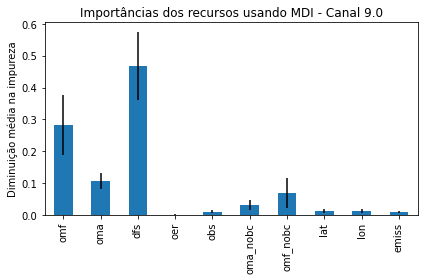


Relatório de Classificação para o canal 9.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.99      0.99      0.99       552
Impacto negativo baixo       0.98      0.99      0.99      1287
 Impacto positivo alto       0.95      0.75      0.84        51
Impacto positivo baixo       0.98      0.98      0.98       910

              accuracy                           0.98      2800
             macro avg       0.98      0.93      0.95      2800
          weighted avg       0.98      0.98      0.98      2800

Matriz de Confusão para o canal 10.0:
[[ 581    9    0    0]
 [   3 1290    0    7]
 [   0    0   54    6]
 [   1   16    2  831]]


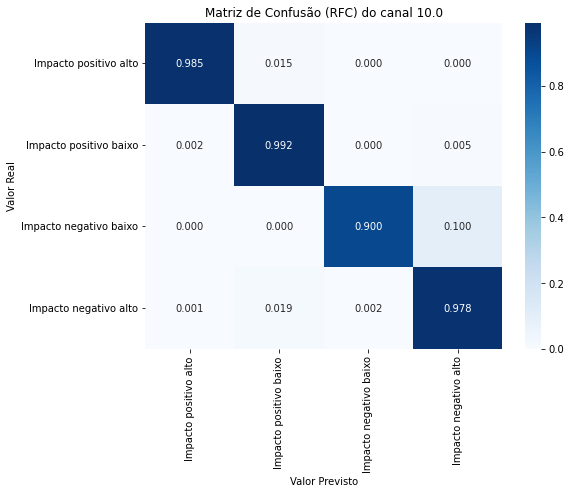

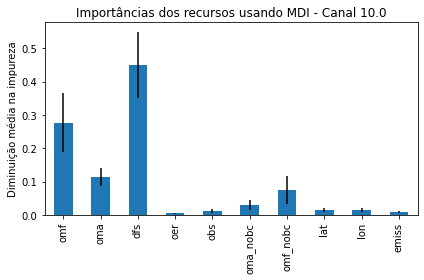


Relatório de Classificação para o canal 10.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.99      0.98      0.99       590
Impacto negativo baixo       0.98      0.99      0.99      1300
 Impacto positivo alto       0.96      0.90      0.93        60
Impacto positivo baixo       0.98      0.98      0.98       850

              accuracy                           0.98      2800
             macro avg       0.98      0.96      0.97      2800
          weighted avg       0.98      0.98      0.98      2800

Matriz de Confusão para o canal 12.0:
[[ 929    6    0    0]
 [  11 1038    0    8]
 [   0    0  134    1]
 [   0   12   10  649]]


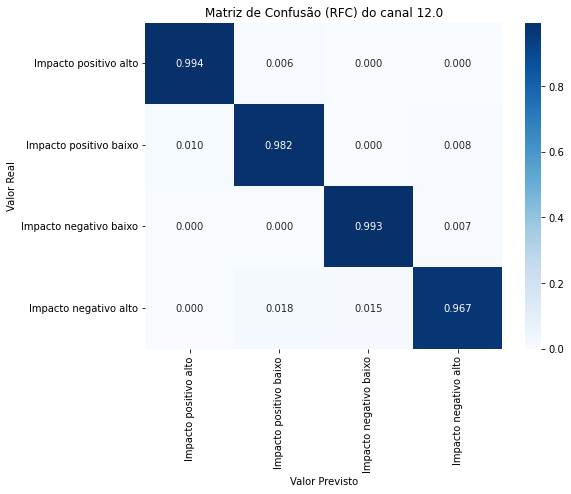

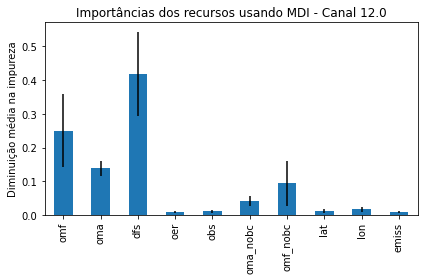


Relatório de Classificação para o canal 12.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.99      0.99      0.99       935
Impacto negativo baixo       0.98      0.98      0.98      1057
 Impacto positivo alto       0.93      0.99      0.96       135
Impacto positivo baixo       0.99      0.97      0.98       671

              accuracy                           0.98      2798
             macro avg       0.97      0.98      0.98      2798
          weighted avg       0.98      0.98      0.98      2798

Matriz de Confusão para o canal 13.0:
[[1134   14    0    0]
 [   7  863    0   12]
 [   0    0  194    4]
 [   0    9    5  555]]


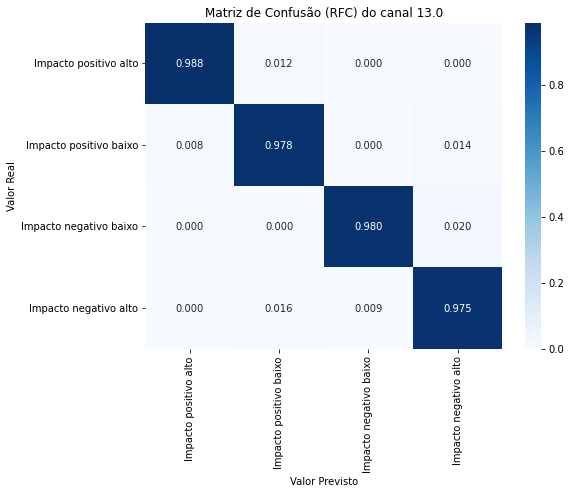

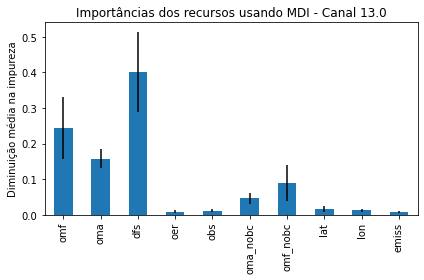


Relatório de Classificação para o canal 13.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.99      0.99      0.99      1148
Impacto negativo baixo       0.97      0.98      0.98       882
 Impacto positivo alto       0.97      0.98      0.98       198
Impacto positivo baixo       0.97      0.98      0.97       569

              accuracy                           0.98      2797
             macro avg       0.98      0.98      0.98      2797
          weighted avg       0.98      0.98      0.98      2797

Matriz de Confusão para o canal 5.0:
[[0 0]
 [1 1]]


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patr

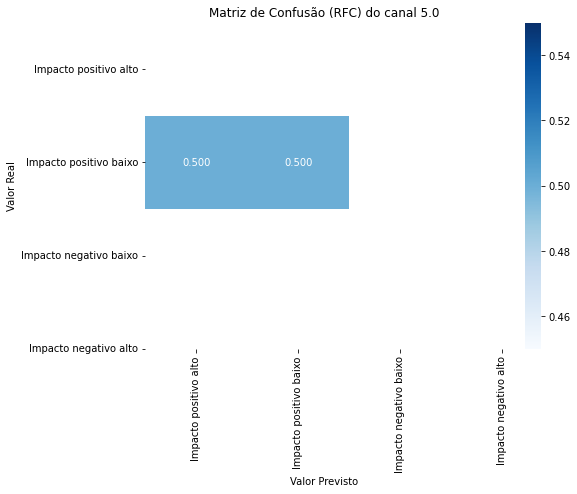

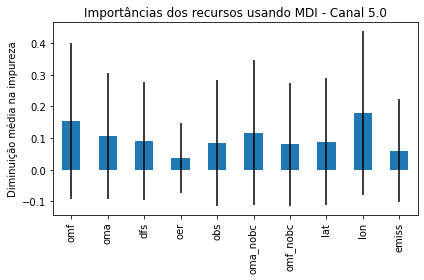

/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patr


Relatório de Classificação para o canal 5.0:
                        precision    recall  f1-score   support

Impacto negativo baixo       0.00      0.00      0.00         0
 Impacto positivo alto       1.00      0.50      0.67         2

              accuracy                           0.50         2
             macro avg       0.50      0.25      0.33         2
          weighted avg       1.00      0.50      0.67         2

Matriz de Confusão para o canal 1.0:
[[1 0]
 [1 0]]


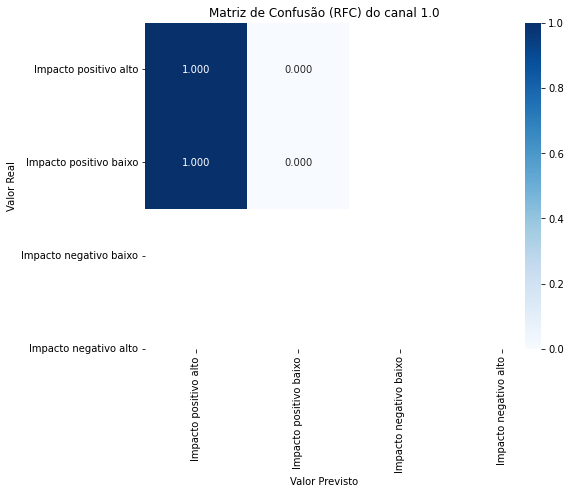

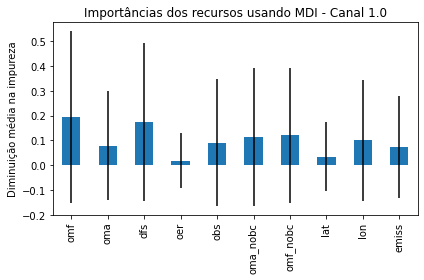

/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Relatório de Classificação para o canal 1.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.50      1.00      0.67         1
Impacto negativo baixo       0.00      0.00      0.00         1

              accuracy                           0.50         2
             macro avg       0.25      0.50      0.33         2
          weighted avg       0.25      0.50      0.33         2

Matriz de Confusão para o canal 2.0:
[[0 1]
 [1 0]]


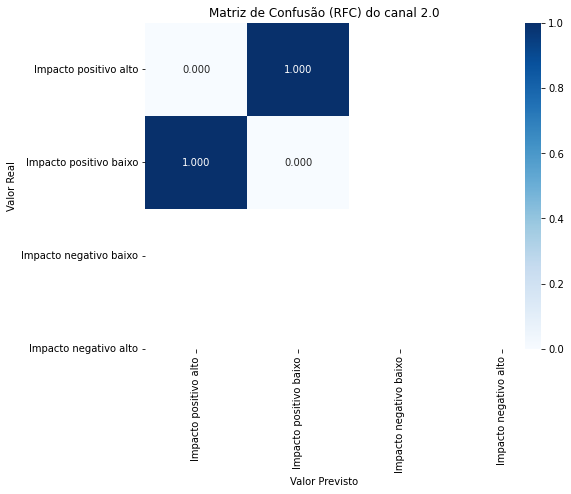

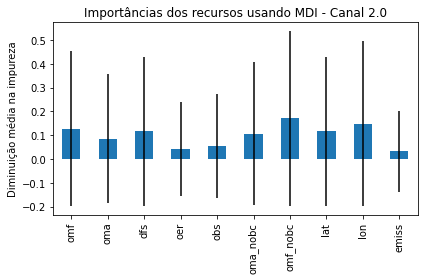


Relatório de Classificação para o canal 2.0:
                        precision    recall  f1-score   support

Impacto negativo baixo       0.00      0.00      0.00       1.0
Impacto positivo baixo       0.00      0.00      0.00       1.0

              accuracy                           0.00       2.0
             macro avg       0.00      0.00      0.00       2.0
          weighted avg       0.00      0.00      0.00       2.0

Matriz de Confusão para o canal 3.0:
[[2]]


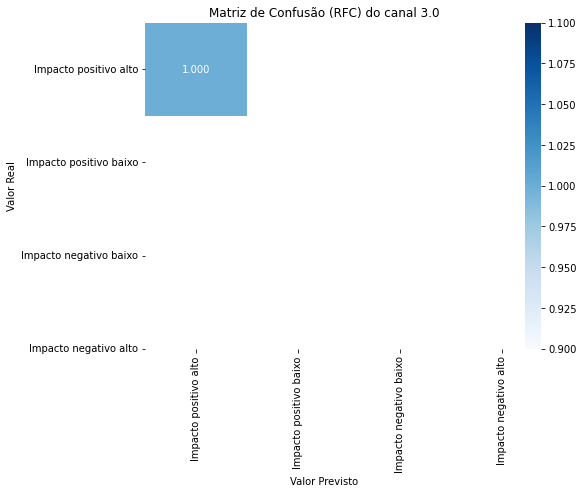

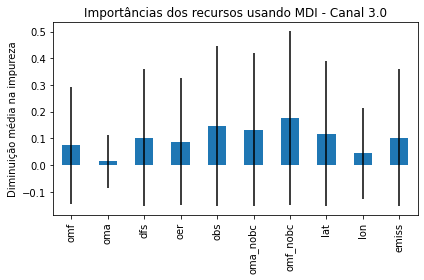


Relatório de Classificação para o canal 3.0:
                       precision    recall  f1-score   support

Impacto positivo alto       1.00      1.00      1.00         2

             accuracy                           1.00         2
            macro avg       1.00      1.00      1.00         2
         weighted avg       1.00      1.00      1.00         2

Matriz de Confusão para o canal 4.0:
[[2]]


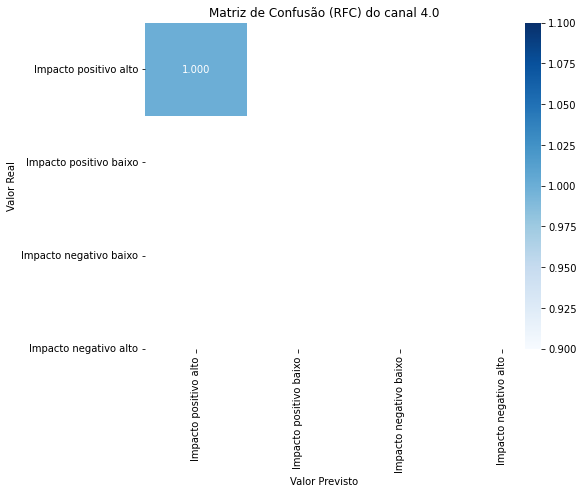

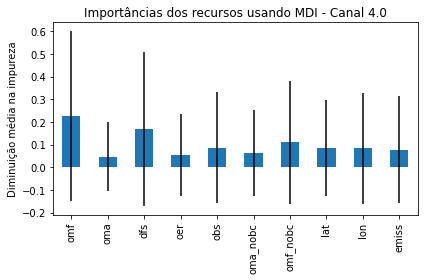


Relatório de Classificação para o canal 4.0:
                       precision    recall  f1-score   support

Impacto negativo alto       1.00      1.00      1.00         2

             accuracy                           1.00         2
            macro avg       1.00      1.00      1.00         2
         weighted avg       1.00      1.00      1.00         2

Matriz de Confusão para o canal 15.0:
[[0 0 0]
 [1 0 0]
 [1 0 0]]


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

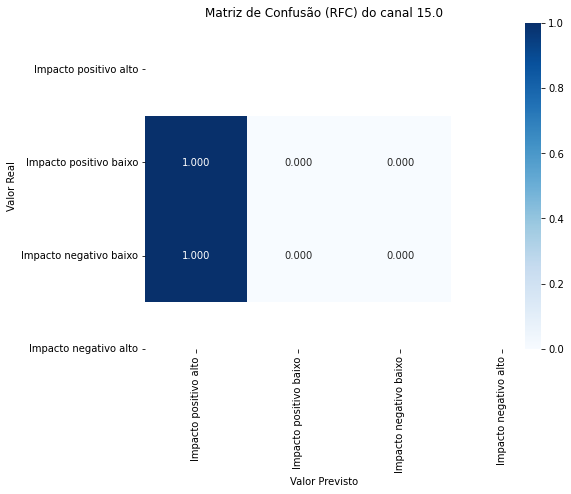

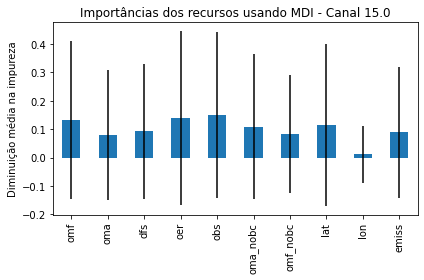


Relatório de Classificação para o canal 15.0:
                        precision    recall  f1-score   support

 Impacto negativo alto       0.00      0.00      0.00       0.0
Impacto negativo baixo       0.00      0.00      0.00       1.0
 Impacto positivo alto       0.00      0.00      0.00       1.0

              accuracy                           0.00       2.0
             macro avg       0.00      0.00      0.00       2.0
          weighted avg       0.00      0.00      0.00       2.0

Modelo do canal: 5.0
Precisão Média: 1.0


Modelo do canal: 3.0
Precisão Média: 1.0


Modelo do canal: 4.0
Precisão Média: 1.0


Modelo do canal: 7.0
Precisão Média: 0.9874642192390714


Modelo do canal: 8.0
Precisão Média: 0.986750616866285


Modelo do canal: 10.0
Precisão Média: 0.9842913245942875


Modelo do canal: 12.0
Precisão Média: 0.9830195331070766


Modelo do canal: 9.0
Precisão Média: 0.9827199091466504


Modelo do canal: 6.0
Precisão Média: 0.9818455455727659


Modelo do canal: 13.0
Pr

/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [9]:
# Define as classes para a matriz de confusão
classes = ["Impacto positivo alto", "Impacto positivo baixo", "Impacto negativo baixo", "Impacto negativo alto"]

# Supondo que 'df' seja o seu DataFrame e 'canal' seja a coluna que contém os canais de radiância
#canais = df_concatenado2['nchan'].unique()  # Obtém a lista de canais únicos
canais = [6, 7, 8, 9, 10, 12, 13]

# Imprime a lista de canais únicos
print(canais)

# Para cada canal, divida o DataFrame e treine um modelo
atributos = ['omf', 'oma', 'dfs', 'oer', 'obs', 'oma_nobc', 'omf_nobc', 'lat', 'lon', 'emiss']

# Lista para armazenar modelos de cada canal e resultados
modeloscanais = []
resultados = []


for canal in canais:
    # Divida o DataFrame para o canal atual
    df_canal = pd.DataFrame()
    df_canal = df_concatenado2[df_concatenado2['nchan'] == canal]
    
    # Verifique se a coluna 'canal' está presente
    if 'nchan' in df_canal.columns:
        # Separe os recursos (X) e o alvo (y)
        X = df_canal[atributos]
        y = df_canal['imp_categ']
        
        # Divida os dados em conjuntos de treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Treine o modelo RandomForestClassifier para o canal atual
        nome_modelo = f"modeloch{canal}"
        modeloch = RandomForestClassifier()
        modeloscanais.append((nome_modelo, modeloch))
        modeloch.fit(X_train, y_train)
        
        # Faça previsões
        y_pred = modeloch.predict(X_test)
        
        # Avalie o modelo e imprima a matriz de confusão
        matriz_confusao = confusion_matrix(y_test, y_pred)
        print(f"Matriz de Confusão para o canal {canal}:")
        print(matriz_confusao)
    else:
        print(f"Coluna 'canal' não encontrada para o canal {canal}. Verifique se os dados estão formatados corretamente.")
        
    # Calcule a precisão média usando o relatório de classificação
    precisao_media = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision']
    resultados.append((canal, precisao_media))
    
    # Calcula a soma de cada linha da matriz de confusão
    sum_by_class = np.sum(matriz_confusao, axis=1)

    # Normaliza a matriz de confusão
    matriz_confusao_normalized = matriz_confusao / sum_by_class[:, np.newaxis]

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao_normalized, annot=True, fmt=".3f", 
                cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Matriz de Confusão (RFC) do canal {canal}")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.savefig(f"MatrizConfusao_Channel_{canal}.png", facecolor='white')
    plt.show()

    
    # Calcula a importância dos recursos para o modelo
    importances = modeloch.feature_importances_
    std = np.std([tree.feature_importances_ for tree in modeloch.estimators_], axis=0)

    # Plota a importância dos recursos usando a diminuição média na impureza
    forest_importances = pd.Series(importances, index=atributos)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Importâncias dos recursos usando MDI - Canal {canal}")
    ax.set_ylabel("Diminuição média na impureza")
    fig.tight_layout()
    plt.savefig(f"FeatureImportance_Channel_{canal}.png", facecolor='white')
    plt.show()
    
    # Gera e imprime o relatório de classificação para o canal atual
    relatorio_classificacao = classification_report(y_test, y_pred)
    print(f"\nRelatório de Classificação para o canal {canal}:")
    print(relatorio_classificacao)
    
# Classifica os resultados por precisão média e imprime os resultados ordenados
resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)
for canal, precisao_media in resultados_ordenados:
    print(f"Modelo do canal: {canal}")
    print(f"Precisão Média: {precisao_media}")
    print("\n")

In [10]:
# Ajustar o LabelBinarizer com os rótulos de treinamento
label_binarizer = LabelBinarizer().fit(y_train)

# Transformar os rótulos de teste em codificação one-hot
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

# Obter as pontuações de probabilidade previstas pelo modelo
y_score = modeloRFC.fit(X_train, y_train).predict_proba(X_test)

# Criar todas as combinações possíveis de pares de classes únicas
pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

# Lista para armazenar as pontuações AUC para cada par de classe
pair_scores = []

# Dicionário para armazenar as médias das taxas de verdadeiros positivos (TPR) para cada par de classe
mean_tpr = dict()

# Iterar sobre cada par de classes
for ix, (label_a, label_b) in enumerate(pair_list):
    # Máscaras booleanas para as classes 'a' e 'b' nos dados de teste
    a_mask = y_test == label_a
    b_mask = y_test == label_b
    # Combinação das máscaras 'a' e 'b' em uma máscara 'ab' para obter as instâncias que pertencem a pelo menos uma das classes
    ab_mask = np.logical_or(a_mask, b_mask)

    # Obter os rótulos verdadeiros correspondentes às classes 'a' e 'b'
    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    # Índice da classe 'a' no codificador binário de rótulos
    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]

    # Verificar se a classe 'b' está presente nas classes do codificador binário de rótulos
    if label_b in label_binarizer.classes_:
        # Índice da classe 'b' no codificador binário de rótulos
        idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]
        # Continuação do código abaixo
    else:
        print(f"A classe {label_b} não está presente nos dados de teste.")

    # Calcular as taxas de falsos positivos (FPR) e verdadeiros positivos (TPR) para as classes 'a' e 'b'
    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    # Calcular a faixa de valores de FPR observados nas curvas ROC
    fpr_min = min(np.min(fpr_a), np.min(fpr_b))
    fpr_max = max(np.max(fpr_a), np.max(fpr_b))
    fpr_grid = np.linspace(fpr_min, fpr_max, 100)  # Ajuste o número de pontos conforme necessário
    
    # Inicializar uma matriz para armazenar as médias das taxas de verdadeiros positivos (TPR)
    mean_tpr[ix] = np.zeros_like(fpr_grid)
    # Interpolação das taxas de verdadeiros positivos (TPR) para a faixa de valores de FPR comum
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    # Calcular a pontuação AUC para a média das taxas de verdadeiros positivos (TPR)
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    # Obter os nomes das classes do LabelBinarizer
    target_names = label_binarizer.classes_
    
    # Criar uma figura e eixos para plotar a curva ROC e as curvas ROC individuais
    fig, ax = plt.subplots(figsize=(6, 6))
    # Plotar a curva ROC média e as curvas ROC individuais
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Média {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} como classe positiva",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} como classe positiva",
    )
    
    # Adicionar a linha de chance na plotagem
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance Level')
    
    # Configurar os rótulos dos eixos e o título da plotagem
    ax.set(
        xlabel="Taxa de falso positivo",
        ylabel="Taxa de verdade positiva",
        title=f"{target_names[idx_a]} vs {label_b} curva ROC",
    )
    
    # Salvar a plotagem como um arquivo de imagem
    plt.savefig(f'{target_names[idx_a]} vs {label_b}_curvaROC.png', facecolor='white')

# Imprimir a pontuação AUC macro-média das curvas ROC One-vs-One
print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

NameError: name 'modeloRFC' is not defined